# Smartphones dataset (Using Sklearn and Keras)

##Importing Necessary Libraries

In [203]:
import math

# Data handling and stuff
import pandas as pd
import numpy as np

# Neural Network Magic Libraries (TensorFlow/Keras)
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
from keras import Input

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.preprocessing import TargetEncoder

# Visualization - remove if not used
import matplotlib.pyplot as plt
# import seaborn as sns

Tensorflow/Keras: 3.8.0


##Visualization Formatting

In [204]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## Data Acquisition and Preprocessing
##### Importing and Cleaning initial Dataset for Processing

In [205]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [206]:
# np.random.seed(42)

In [207]:
smartphones = read_csv("Cleaned smartphones.csv")
cleaned_smartphones = clean_data(smartphones)
cleaned_smartphones.head()
cleaned_smartphones.info()

y = cleaned_smartphones["price"]
X = cleaned_smartphones.drop("price", axis=1)


categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    te = TargetEncoder(target_type="continuous", random_state=42, smooth = 'auto')
    data_array = X[col].values.reshape(-1, 1)
    X[col] = te.fit_transform(X[[col]], y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand_name                 870 non-null    object 
 1   price                      870 non-null    float64
 2   avg_rating                 870 non-null    float64
 3   5G_or_not                  870 non-null    int64  
 4   processor_brand            870 non-null    object 
 5   num_cores                  870 non-null    float64
 6   processor_speed            870 non-null    float64
 7   battery_capacity           870 non-null    float64
 8   fast_charging_available    870 non-null    int64  
 9   ram_capacity               870 non-null    int64  
 10  internal_memory            870 non-null    int64  
 11  screen_size                870 non-null    float64
 12  refresh_rate               870 non-null    int64  
 13  num_rear_cameras           870 non-null    int64  

##Building our Feedforward Neural Network

##### Splitting training and testing samples

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Scaling our Data for Processing

In [209]:
# Scale Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# Scale Target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [210]:
def predict_price_with_margin(model, scaler, X_data):
    """Returns predictions with dollar margins"""
    scaled_pred = model.predict(X_data)
    pred_dollars = scaler.inverse_transform(scaled_pred).flatten()
    mae_dollars = mean_absolute_error(
        scaler.inverse_transform(y_test_scaled).flatten(),
        pred_dollars
    )
    return pred_dollars, mae_dollars


##### Defining the Structure of the Neural Network

In [211]:
model = Sequential(name="Smartphones_NN")
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01))) # Input Layer
model.add(BatchNormalization())
model.add(Dropout(0.2)) # Deactivates 20% of neurons if they are not improving performance
model.add(Dense(32, activation='relu')) # Hidden Layer 1
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu')) # Hidden Layer 2
model.add(BatchNormalization())
model.add(Dense(1)) # Output Layer

##### Compile Keras model aka Magic

In [212]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=Huber(delta=1.0),  # Handles Outliers better than mse
    metrics=['mae']
)

In [213]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

X_train_scaled shape: (609, 19)
y_train_scaled shape: (609, 1)


##### Fitting keras model onto the dataset

In [214]:
batch_size = 64
early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,         # Reduce LR by 50%
    patience=5,         # Wait 5 epochs w/o improvement before reducing LR
    min_lr=1e-5,        # Smallest allowed LR
    verbose=1           # Print a message when LR changes
)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=200,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr, early_stop])


# model.fit(X_train_scaled, y_train_scaled, batch_size=batch_size,steps_per_epoch=steps_per_epoch, epochs=10)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0502 - mae: 1.2108 - val_loss: 0.4173 - val_mae: 0.5257 - learning_rate: 0.0050
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5648 - mae: 0.6798 - val_loss: 0.3707 - val_mae: 0.4555 - learning_rate: 0.0050
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4515 - mae: 0.5353 - val_loss: 0.3628 - val_mae: 0.4636 - learning_rate: 0.0050
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4292 - mae: 0.5223 - val_loss: 0.3377 - val_mae: 0.4381 - learning_rate: 0.0050
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3655 - mae: 0.4478 - val_loss: 0.3109 - val_mae: 0.4148 - learning_rate: 0.0050
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3572 - mae: 0.4509 - val_loss: 0.2881 - val_mae: 0.3916 - learning_rate: 0.0050
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3187 - mae: 0.4135 - val_loss: 0.2590 - val_mae: 0.3494 - learning_rate: 0.0050
Epoch 

##### Making Predictions with our model

Evaluating model

In [215]:
# Get your scaled test predictions
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform BOTH predictions and true values
y_pred_dollars = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_dollars = scaler_y.inverse_transform(y_test_scaled).flatten()

# Calculate MAE in original dollars
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MAE: {test_mae:.4f}")
mae_dollars = mean_absolute_error(y_true_dollars, y_pred_dollars)

print(f"Official Test MAE (USD): ±${mae_dollars:.2f}")
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true_dollars, y_pred_dollars):.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test MAE: 0.2443
Official Test MAE (USD): ±$41.47
Mean Absolute Percentage Error: 0.17


Bias Check

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Text(0.5, 1.0, 'Error Distribution')

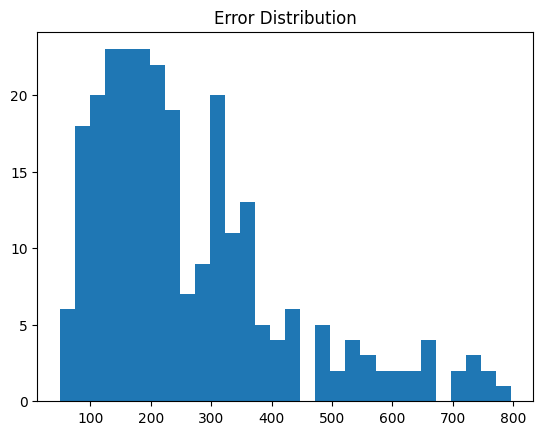

In [216]:
predictions = model.predict(X_test_scaled)
errors = y_test - predictions.flatten()
plt.hist(errors, bins=30)
plt.title("Error Distribution")

In [217]:
# Make predictions and compare with true values
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


##Plots

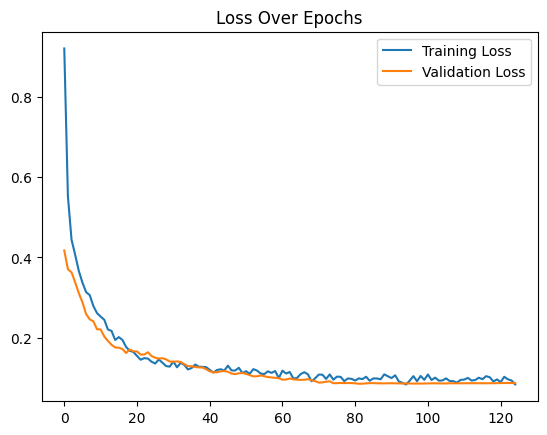

In [218]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()



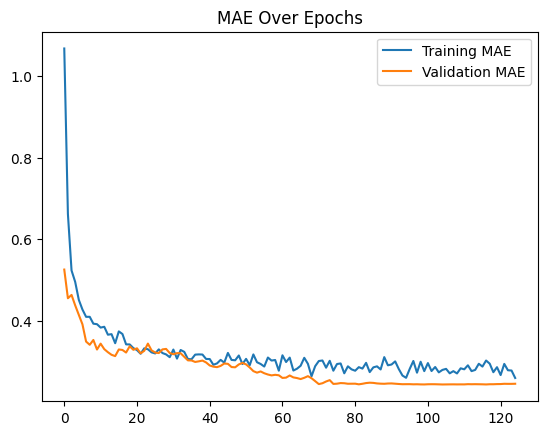

In [219]:
# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.legend()
plt.show()

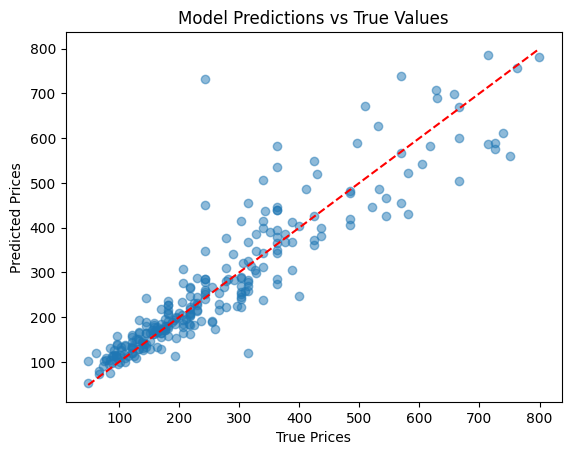

In [220]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()